In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import random  
import copy 
import csv 
import time
import pandas as pd 
import numpy as np 

In [2]:
def initializeMap(p_zero, N):
    amap = np.zeros((N,N))
    for i in range(0, N):
        for j in range(0, i):
            if random.random() > p_zero:
                amap[i][j] = amap[j][i] = random.random()
                
    return amap 

In [3]:
def initializeComplexMap(p_zero, N, groups):
    amap = np.zeros((N,N))

    for i in range(0, N):
        for j in range(0, i):
            group_i = int(i/(N/groups))
            group_j = int(j/(N/groups))

            if random.random() > p_zero and abs(group_i - group_j) <= 1:
                amap[i][j] = random.random()
                amap[j][i] = amap[i][j]

    ax = sns.heatmap(amap)
    plt.show()
    return amap

In [4]:
def getPueblos(data, start, end):
    allPueblos = []
    skip = [start, end]
    for i in data['source']:
        if i not in allPueblos and i is not np.nan and i not in skip: 
            allPueblos.append(i)
    
    for i in data['dest']:
        if i not in allPueblos and i is not np.nan and i not in skip: 
            allPueblos.append(i)
    if data[data['source']==start].empty:
        print(start + ' not found in available')
    else: 
        allPueblos = [start] + allPueblos

    if data[data['dest']==end].empty:
        print(end + ' not found in available')
    else: 
        allPueblos = allPueblos + [end]
    return allPueblos 

In [5]:
def createMapFromCsv(data, allPueblos):
    N = len(allPueblos)
    amap = np.zeros((N,N))
    print("Source: " + allPueblos[0] + "\nDestination: " + allPueblos[N-1])
    
    for i in range(0, N):
        for j in range(0, N):
            src = allPueblos[i]
            dest = allPueblos[j]
            value = data.loc[(data['source']==src) & (data['dest']==dest)]['weight'].values
            if src == dest: 
                continue 
            else: 
                value = data.loc[(data['source']==src) & (data['dest']==dest)]['weight'].values
                if(len(value)>0):
                    amap[i][j] = amap[j][i] = value[0]
                
    ax = sns.heatmap(amap)
    plt.show()
    return amap 

In [6]:
def createStartingPopulation(size, amap):
    population = []
    for i in range(0,size):
        population.append(createNewMember(amap))
        
    return population

In [7]:
def crossover(a, b):
    common_elements = set(a) & set(b)
    if len(common_elements) == 2:
        return (a, b)
    else:
        common_elements.remove(0)
        common_elements.remove(max(a)) 
        value = random.sample(common_elements, 1)        
    
    cut_a = np.random.choice(np.where(np.isin(a, value))[0])
    cut_b = np.random.choice(np.where(np.isin(b, value))[0])
    
    new_a1 = copy.deepcopy(a[0:cut_a])
    new_a2 = copy.deepcopy(b[cut_b:])
    
    new_b1 = copy.deepcopy(b[0:cut_b])
    new_b2 = copy.deepcopy(a[cut_a:])
    
    new_a = np.append(new_a1, new_a2)
    new_b = np.append(new_b1, new_b2)
       
    return (new_a, new_b)

In [8]:
def mutate(route, probability, amap):
    new_route = copy.deepcopy(route)
    for i in range(1, len(new_route)):
        if random.random() < probability:
            go = True
            while go:
                possible_values = np.nonzero(amap[new_route[i-1]])
                proposed_value = random.randint(0,len(possible_values[0])-1)
                route = np.append(new_route, possible_values[0][proposed_value])

                if new_route[i] == len(amap)-1:
                    go = False
                else:
                    i += 1
    
    return new_route

In [9]:
def createNewMember(amap):
    N = len(amap)
    route = np.zeros(1, dtype=int)
    go = True
    i = 1
    while go:
        possible_values = np.nonzero(amap[route[i-1]])
        proposed_value = random.randint(0,len(possible_values[0])-1)
        route = np.append(route, possible_values[0][proposed_value])
                
        if route[i] == N-1:
            go = False
        else:
            i += 1
    
    return route

In [10]:
def scorePopulation(population, amap):
    scores = []
    for i in range(0, len(population)):
        scores += [fitness(population[i], amap)]
        
    return scores

In [11]:
def pickMate(scores):
    array = np.array(scores)
    temp = array.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(array))

    fitness = [len(ranks) - x for x in ranks]
    cum_scores = copy.deepcopy(fitness)
    for i in range(1,len(cum_scores)):
        cum_scores[i] = fitness[i] + cum_scores[i-1]
        
    probs = [x / cum_scores[-1] for x in cum_scores]
    rand = random.random()
    for i in range(0, len(probs)):
        if rand < probs[i]:
            return i

In [12]:
def fitness(route, amap):
    score = 0
    for i in range(1, len(route)):
        if (amap[route[i-1]][route[i]] == 0) and i != len(amap)-1:
            print("WARNING: INVALID ROUTE")
            print(route)
            print(amap)
        score = score + amap[route[i-1]][route[i]]

    return score

In [13]:
def plotBest(amap,  route, iterNum, allPueblos): 
    plt.figure(figsize = (16,16))
    ax = sns.heatmap(amap, xticklabels=allPueblos, yticklabels=allPueblos)
    
    x = [0.5] + [x + 0.5 for x in route[0:len(route)-1]] + [len(amap) - 0.5] 
    y = [0.5] + [x + 0.5 for x in route[1:len(route)]] + [len(amap) - 0.5] 

    plt.plot(x,y, marker='o',  linewidth=4, markersize=12, linestyle="-", color='white') 
    plt.savefig('images/new100plot_%i.png' % (iterNum), dpi=300)
    plt.show()


Source: Cayey
Destination: Ponce


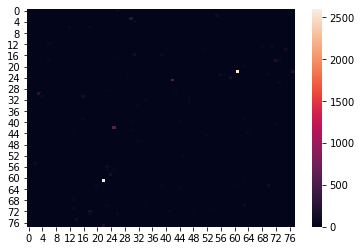

Iterations 0: best so far is 2 steps for a distance of 1.760000


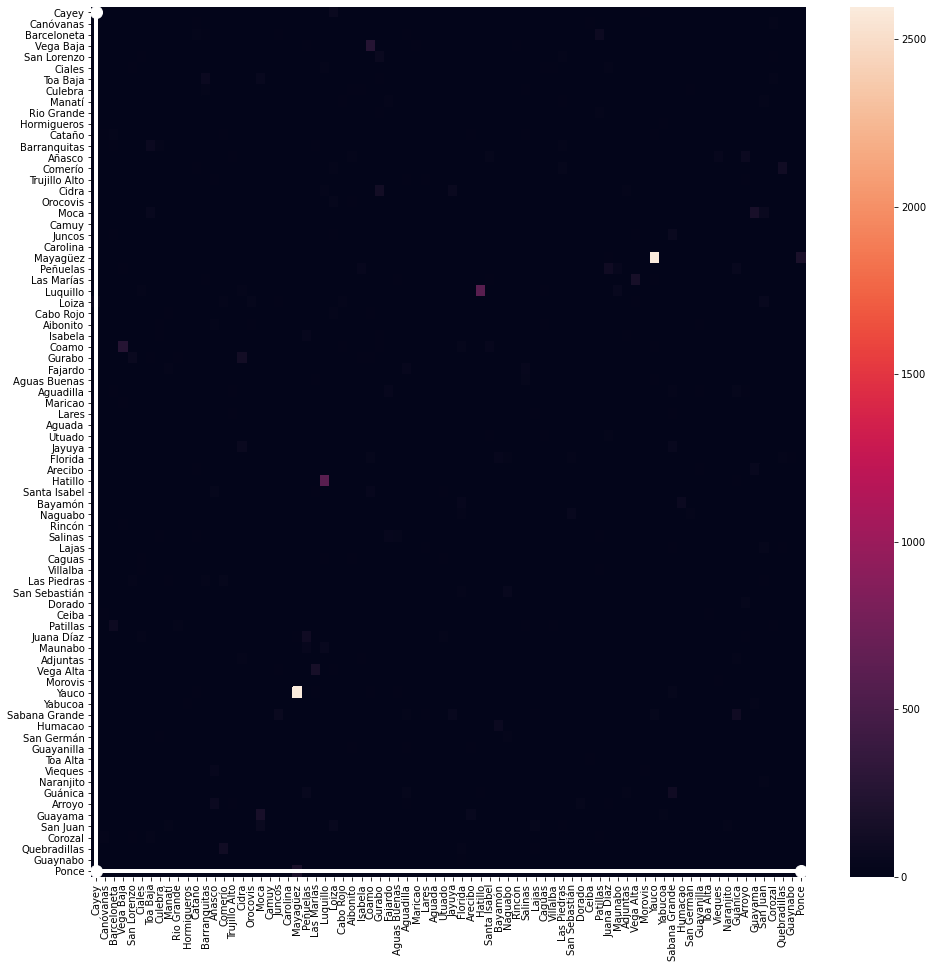

5.806615114212036


In [25]:
sparsenessOfMap = 0.95
sizeOfMap = 1000 
populationSize = 30 
numIterations = 10 #1000 
numCouples = 9 
numWinnerToKeep = 2 
mutationProb = 0.05 
numOfGroups = 1 
filename = "../map.csv"

StartPueblo = 'Cayey'
EndPueblo = 'Ponce'

csv = pd.read_csv(filename, names=['source', 'dest', 'weight'],usecols=[0, 1, 5]) 
pueblos = getPueblos(csv, StartPueblo, EndPueblo)
amap = createMapFromCsv(csv, pueblos) 
population = createStartingPopulation(populationSize, amap)

start = time.time()
lastDist = 1000000000

for i in range(0, numIterations): 
    newPop = [] 
    scores = scorePopulation(population, amap)
    
    best = population[np.argmin(scores)]
    numOfMoves = len(best)
    dist = fitness(best, amap)
    
    if dist != lastDist: 
        print("Iterations %i: best so far is %i steps for a distance of %f" % (i, numOfMoves, dist))
        plotBest(amap, best, i, pueblos)
    
    for j in range(0, numCouples):
        new1, new2 = crossover(population[pickMate(scores)], population[pickMate(scores)])
        newPop = newPop + [new1, new2]
        
    for j in range(0, len(newPop)): 
        newPop[j] = np.copy(mutate(newPop[j], 0.05, amap))
        
    newPop += [population[np.argmin(scores)]]
    for j in range(1, numWinnerToKeep): 
        keeper = pickMate(scores)
        newPop += [population[keeper]]
        
    while len(newPop) < populationSize:
        newPop += [createNewMember(amap)]
    
    population = copy.deepcopy(newPop)
    lastDist = dist 
end = time.time()
print(end-start)